### Nama Anggota:
Bryan Yapdhika 2110511070<br>
Hilmi Aziz Zain 2110511064<br>
Kamila Dinia Kartono 2110511100<br>

# Tahap 1: Melakukan Importasi library yang dibutuhkan.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load dataset
dataset = pd.read_csv('diabetes.csv')
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# Tahap 2: Mengecek dataset diabetes

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# Kolom 6 memiliki nama yang terlalu panjang, dan ini akan sangat menggangung apabila ingin melakukan visualisasi pada data kolom.
dataset.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)

In [5]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


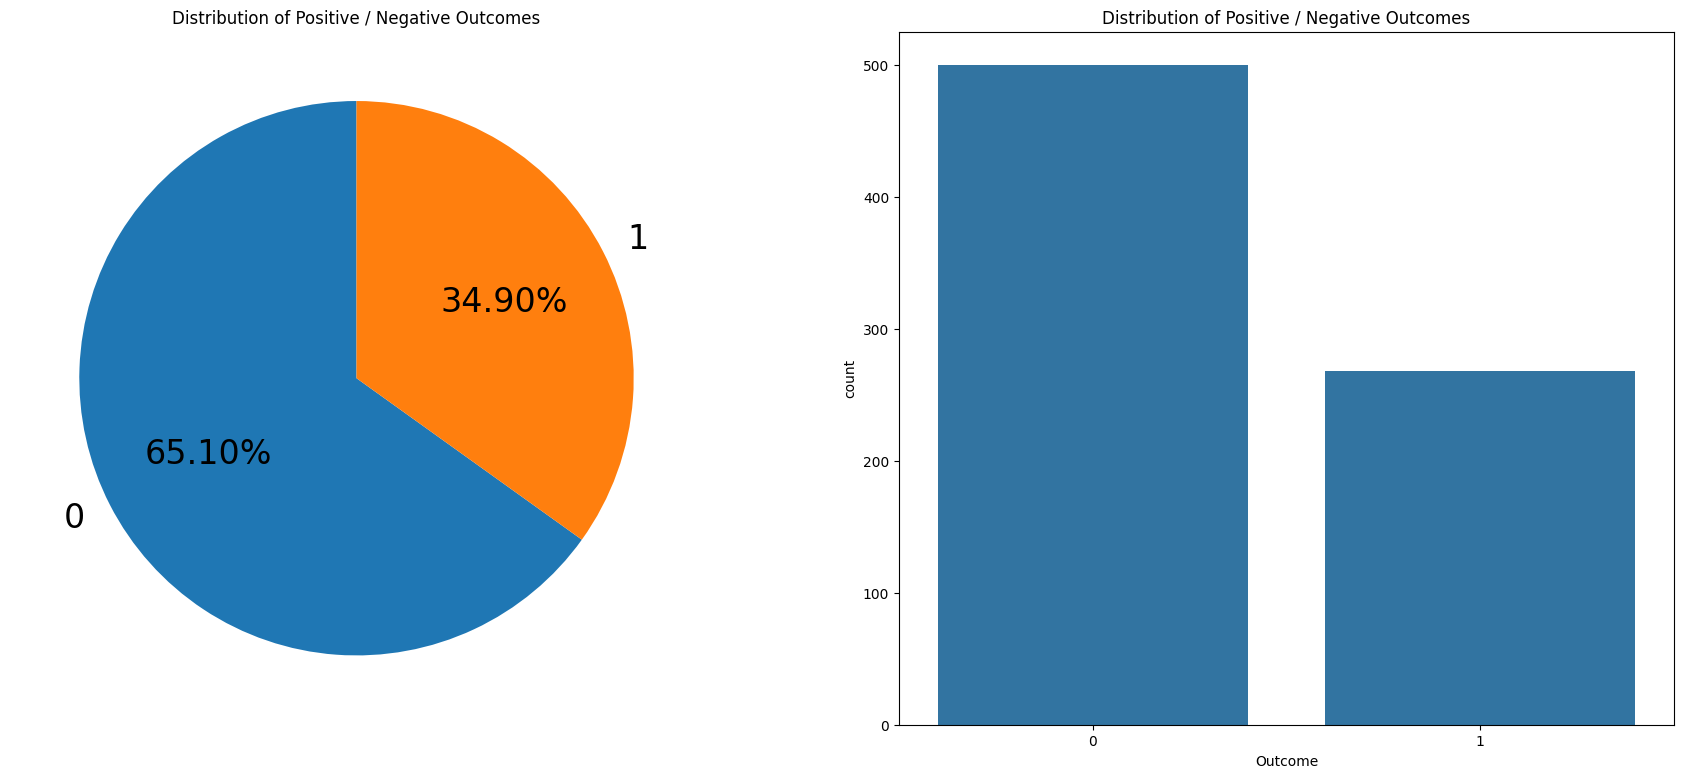

Jumlah Nilai 0 (Tidak Diabetes): 500
Jumlah Nilai 1 (Diabetes): 268


In [6]:
a, ax = plt.subplots(1,2,figsize=(22,9))
dataset['Outcome'].value_counts().plot.pie(explode=[0,0], autopct='%1.2f%%',ax=ax[0], startangle=90, textprops={'fontsize': 24})
ax[0].set_title('Distribution of Positive / Negative Outcomes')
ax[0].set_ylabel('')
sns.countplot(x=dataset['Outcome'])
ax[1].set_title('Distribution of Positive / Negative Outcomes')
plt.show()
dataset.groupby(['Outcome'])[['Outcome']].count()
#
outcome_counts = dataset['Outcome'].value_counts()
print("Jumlah Nilai 0 (Tidak Diabetes):", outcome_counts[0])
print("Jumlah Nilai 1 (Diabetes):", outcome_counts[1])

In [7]:
def check_zero(s, props=''):
    styles = []
    min_value = np.nanmin(s.values)
    for value in s:
        if value == min_value:
            styles.append(props)
        else:
            styles.append('')
    
    return styles

dataset.describe().style.apply(check_zero, props='color:white;background-color:blue', axis=0)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
feature_names = [column for column in dataset.iloc[:,:-1].columns]

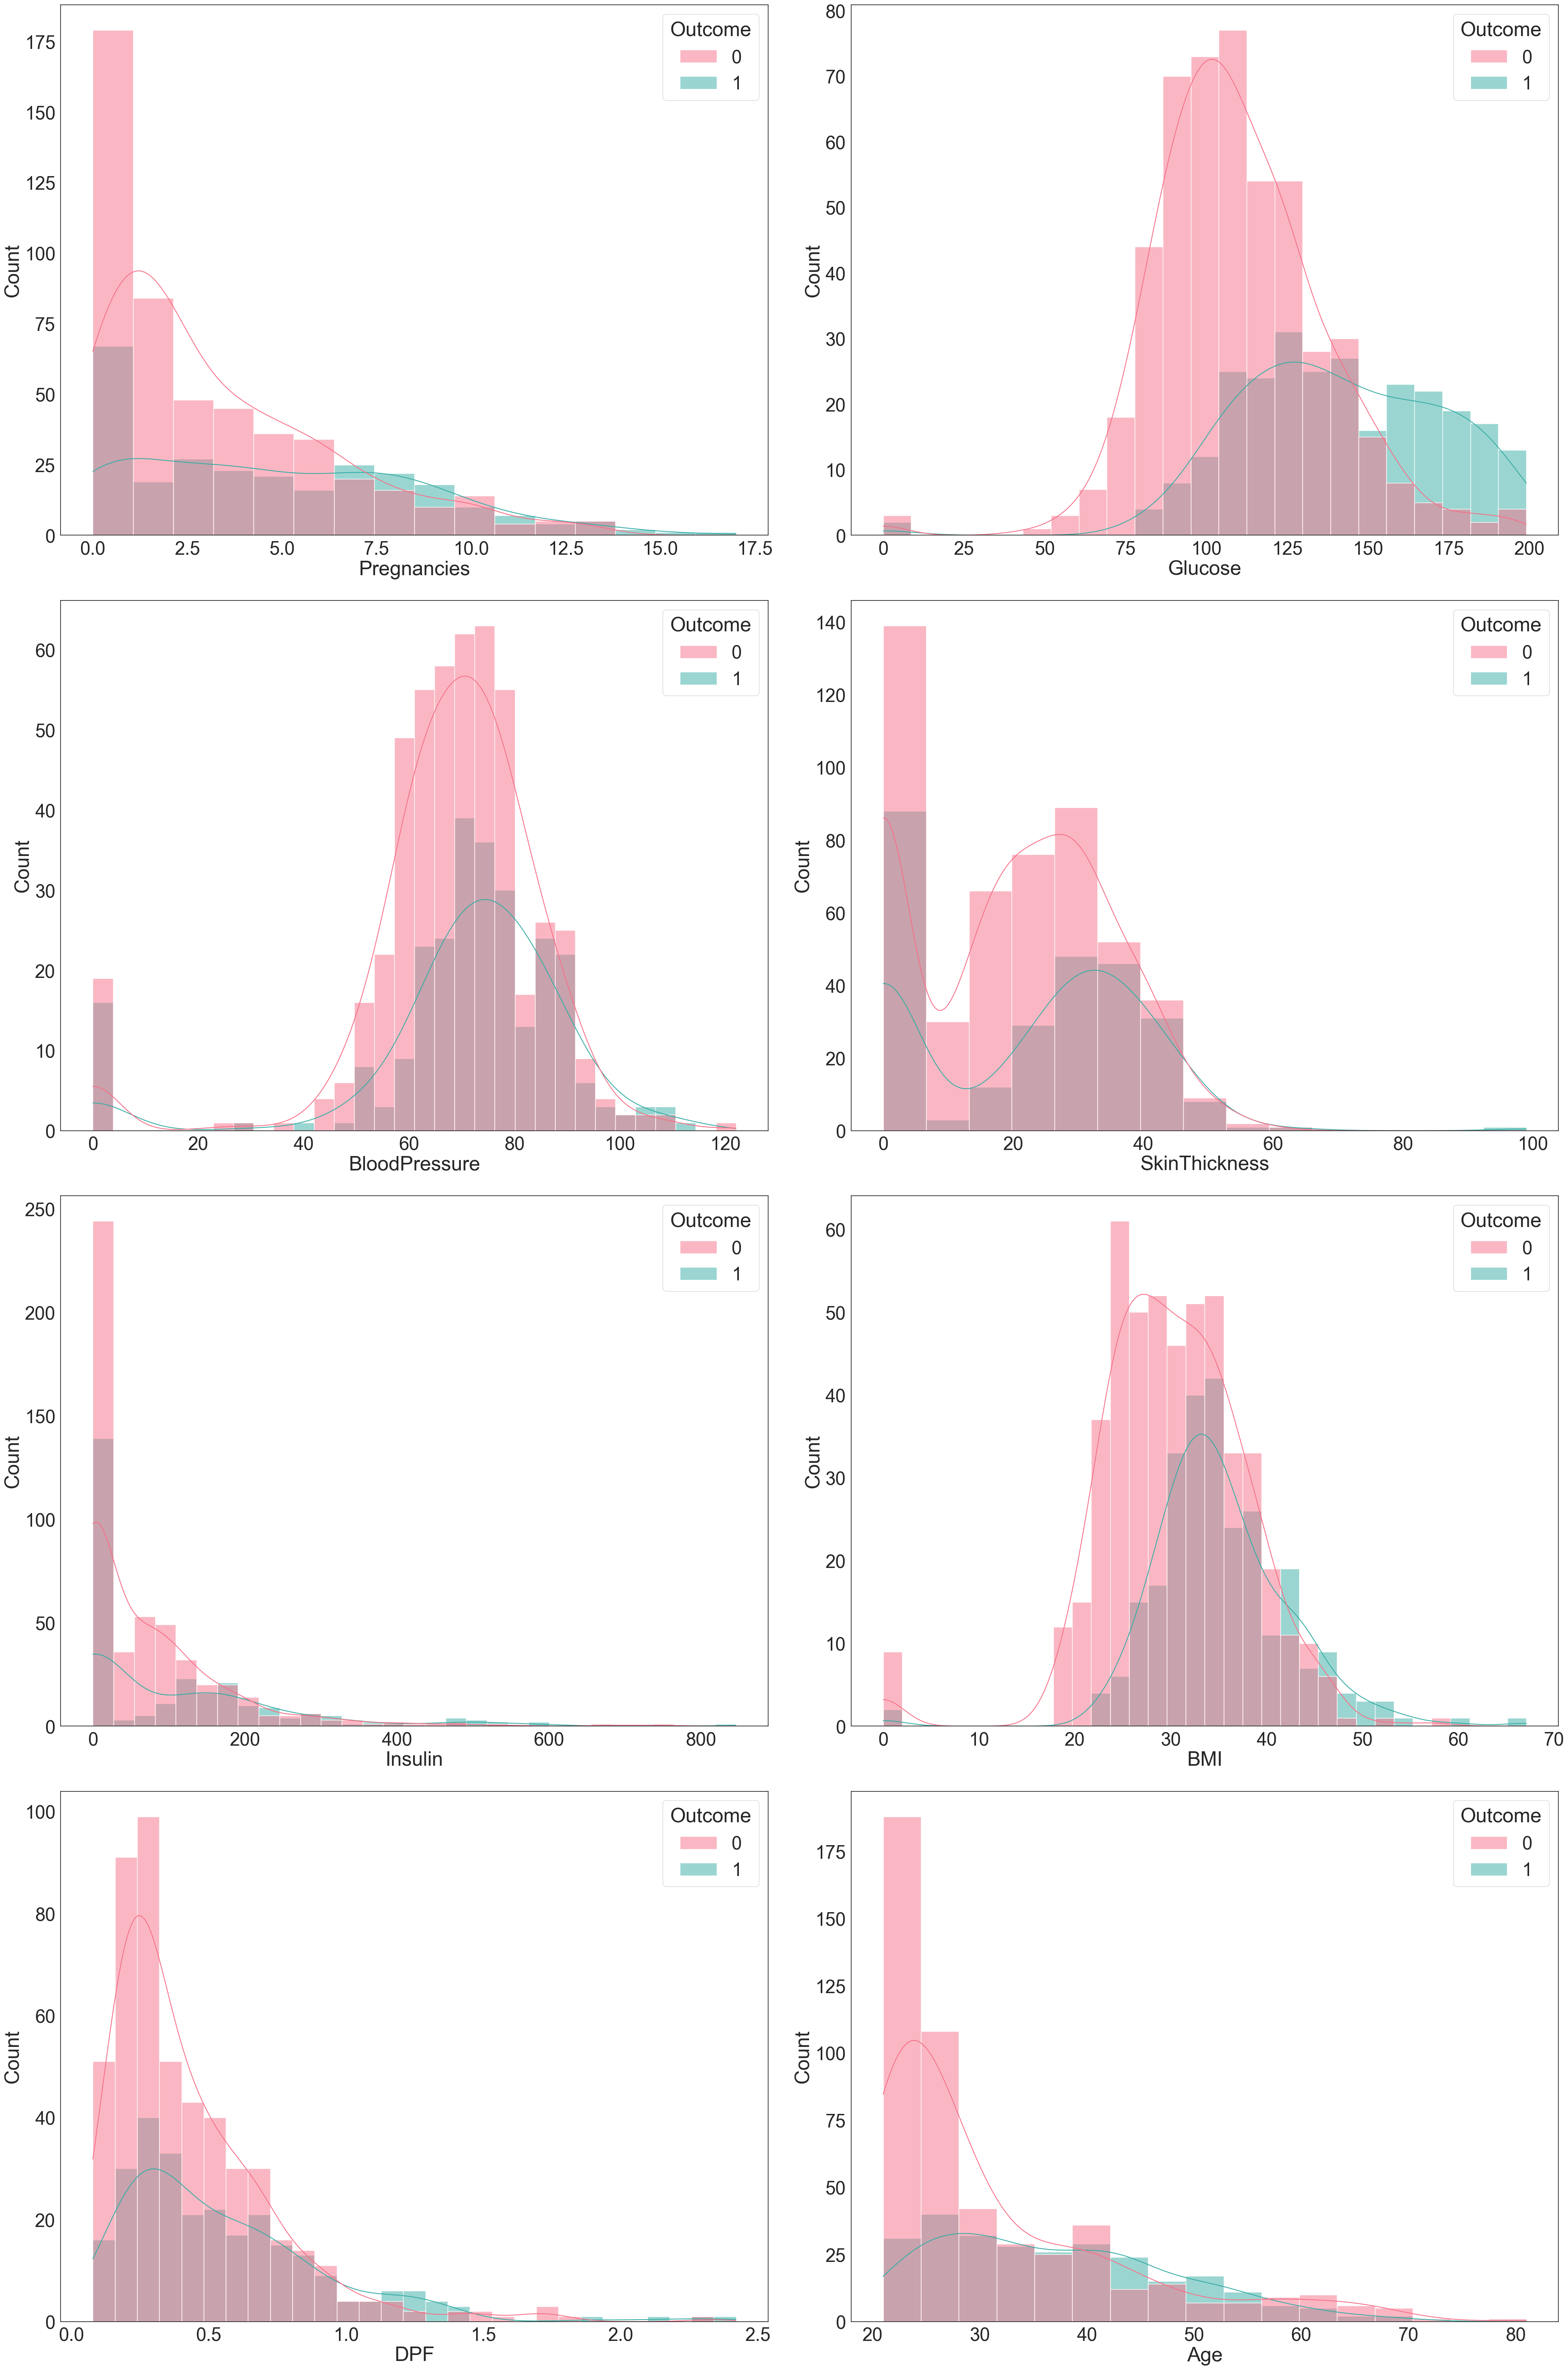

In [9]:
def plot_distribution():
    plt.rcParams['figure.figsize'] = (40, 60)
    sns.set(font_scale=3)
    sns.set_style("white")
    n_rows = 4
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols)
    plt.subplots_adjust(hspace=0.5)

    for i, name in enumerate(feature_names):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        sns.histplot(data=dataset, x=name, hue="Outcome", kde=True, palette="husl", ax=ax)
    plt.tight_layout()
    plt.show()
plot_distribution()

# Tahap 3: Penghapusan nilai yang tiada untuk menangani outlier

In [10]:
#invalid_features = ['Glucose','BloodPressure','SkinThickness','BMI']
invalid_features = ['Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = len(dataset.index)

for feature in invalid_features:
    zero_count = dataset[dataset[feature]==0][feature].count()
    print('Kasus {0} bernilai 0 bertotal {1} baris, dengan persentase {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Kasus Glucose bernilai 0 bertotal 5 baris, dengan persentase 0.65 %
Kasus BloodPressure bernilai 0 bertotal 35 baris, dengan persentase 4.56 %
Kasus SkinThickness bernilai 0 bertotal 227 baris, dengan persentase 29.56 %
Kasus Insulin bernilai 0 bertotal 374 baris, dengan persentase 48.70 %
Kasus BMI bernilai 0 bertotal 11 baris, dengan persentase 1.43 %


In [11]:
diabetes_mean = dataset[invalid_features].mean()

In [12]:
diabetes_mean

Glucose          120.894531
BloodPressure     69.105469
SkinThickness     20.536458
Insulin           79.799479
BMI               31.992578
dtype: float64

In [13]:
dataset[invalid_features]=dataset[invalid_features].replace(0, diabetes_mean)

In [14]:
dataset.describe().style.apply(check_zero, props='color:white;background-color:blue')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


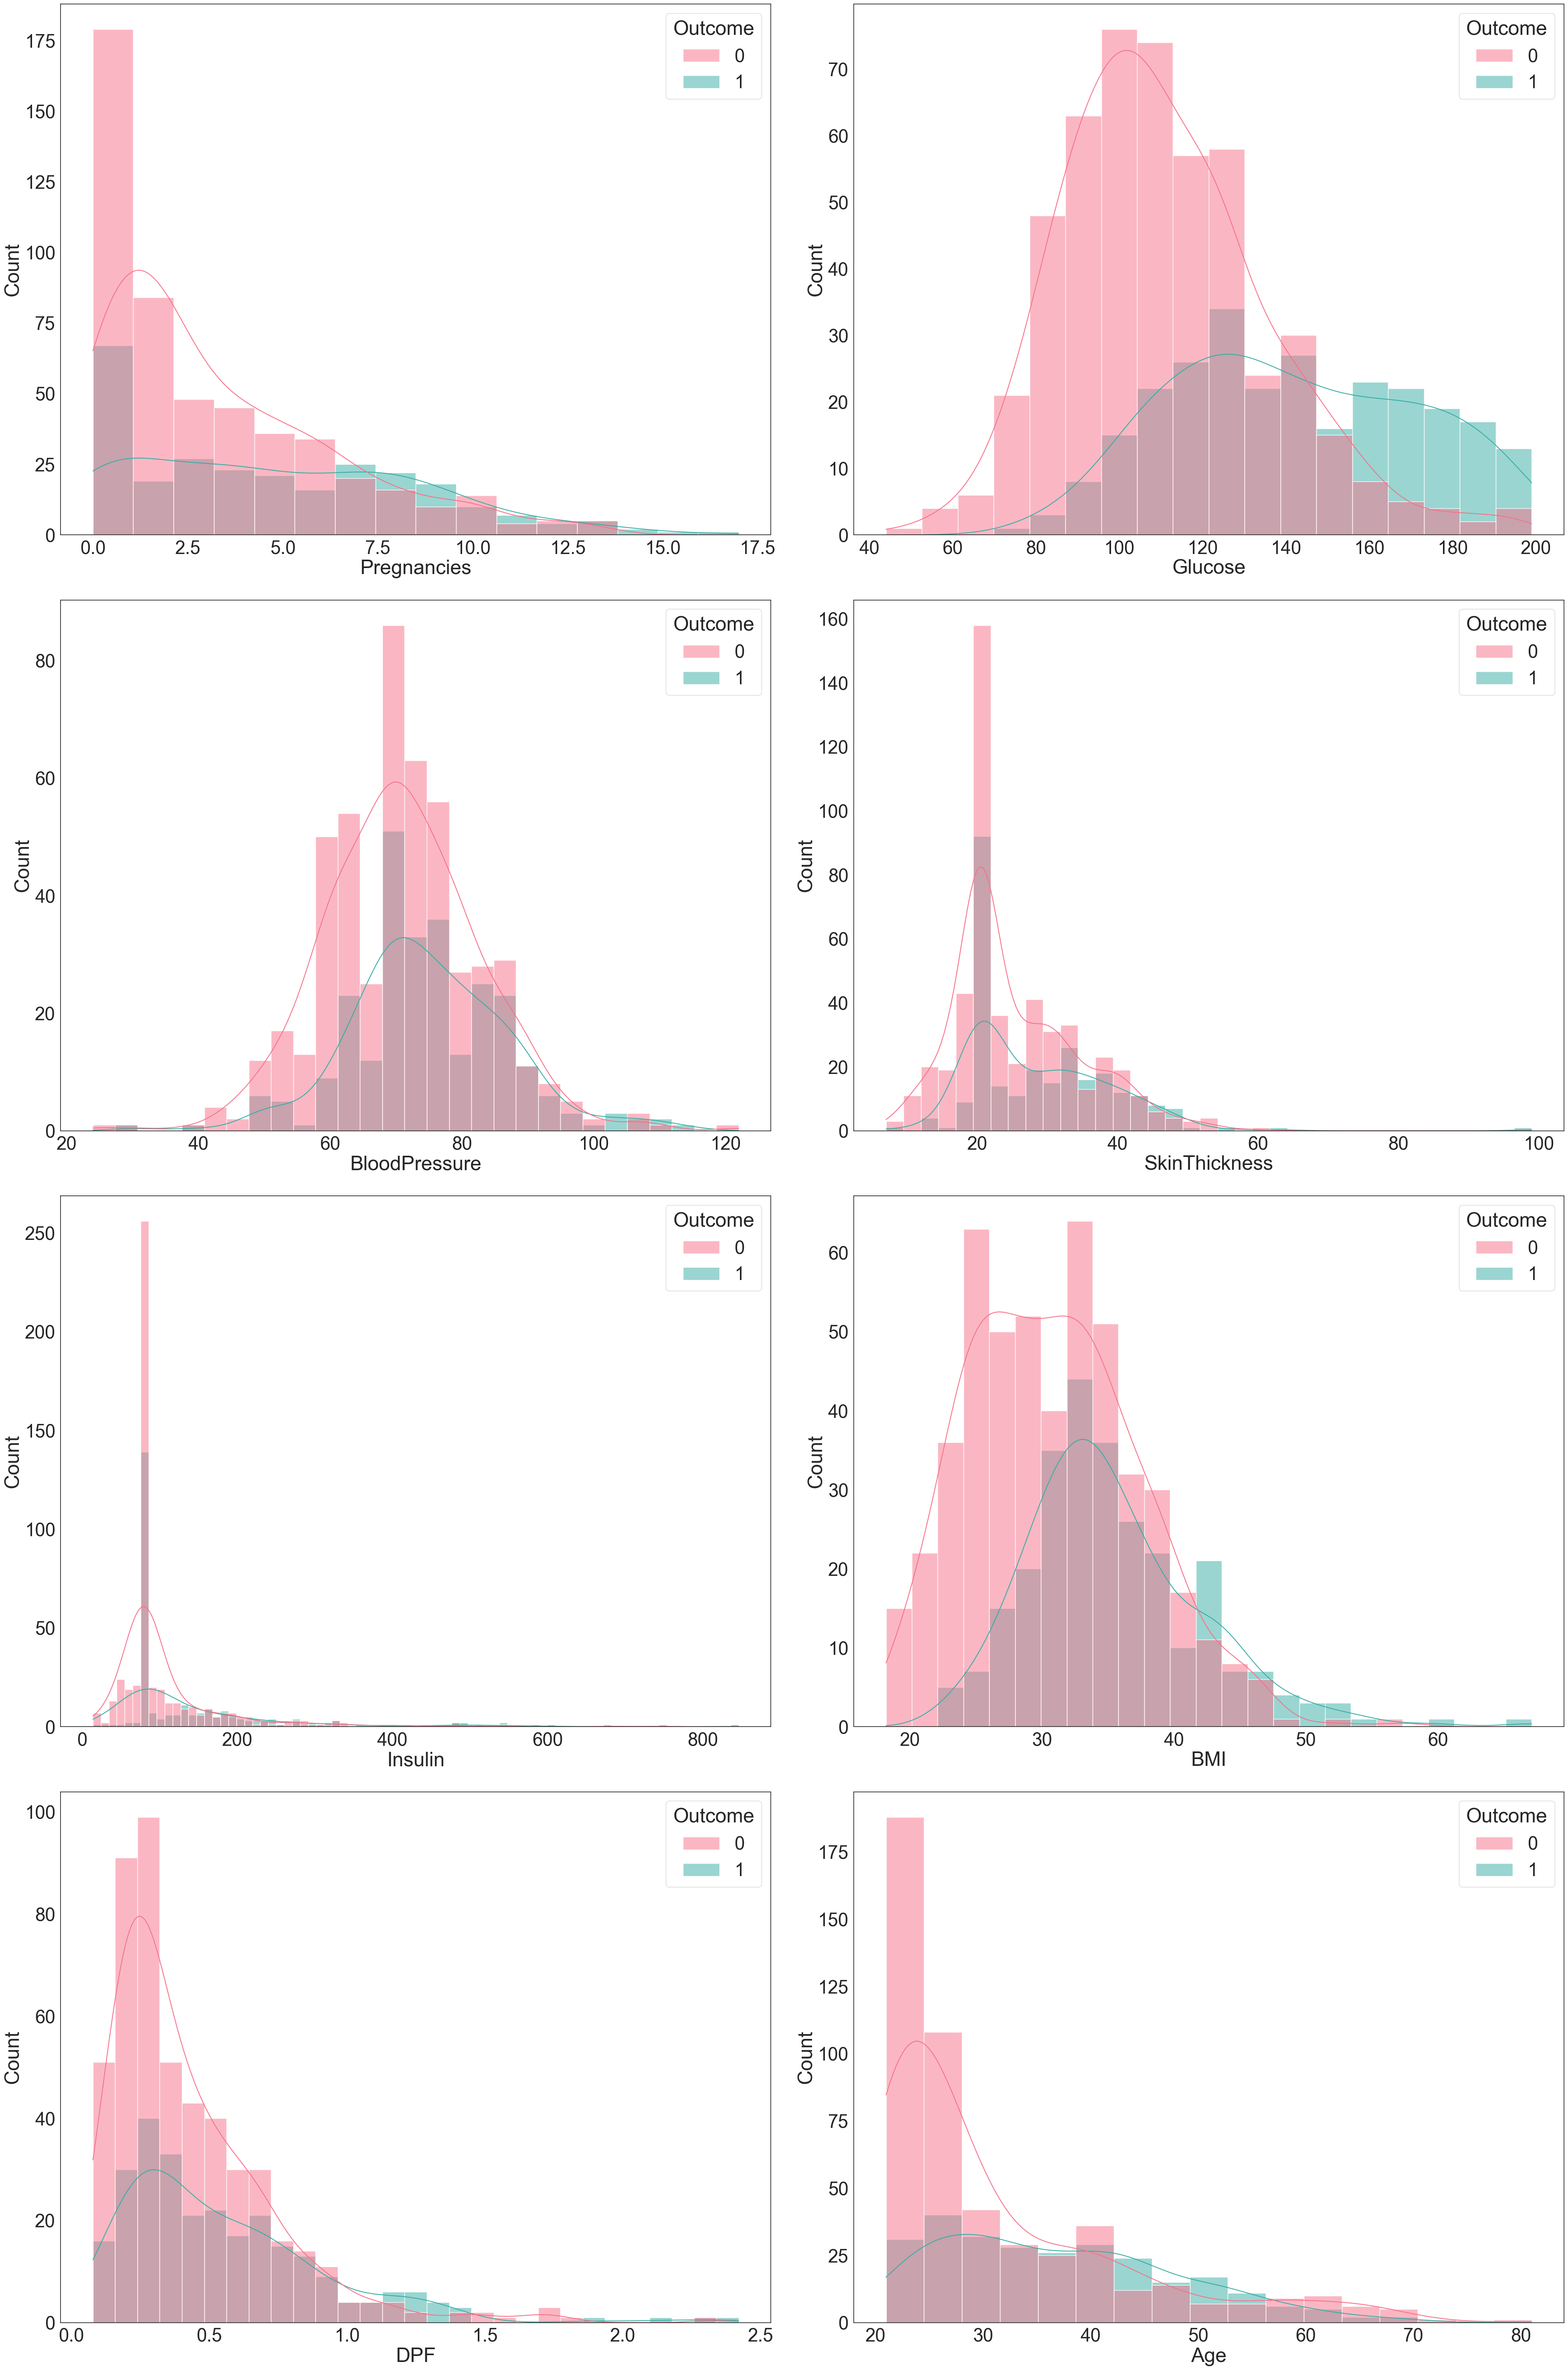

In [15]:
plot_distribution()

In [16]:
# Split data menjadi fitur (X) dan  variabel target (y)
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

# Tahap 4: Melakukan standardisasi untuk mengubah distribusi yang skewed menjadi distribusi normal

In [17]:
# Split  dataset menjadi training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from sklearn.preprocessing import QuantileTransformer
Q_scaler = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
X_train_scaled = Q_scaler.fit_transform(X_train)
X_test_scaled = Q_scaler.transform(X_test)

# std_scaler = StandardScaler()
# X_train_scaled = std_scaler.fit_transform(X_train)
# X_test_scaled = std_scaler.transform(X_test)

In [19]:
# Variabel untuk CM
unique_classes_test, class_counts_test = np.unique(y_test, return_counts=True)
class_counts = len(class_counts_test)

In [20]:
X_train.describe().style.apply(check_zero, props='color:white;background-color:blue', axis=0)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.742671,121.839532,72.116500,26.285695,119.128418,32.348124,0.469168,32.907166
std,3.313264,30.102145,12.114445,9.166801,94.611650,6.935622,0.336847,11.503437
min,0.000000,44.000000,24.000000,8.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,20.536458,79.799479,27.325000,0.241500,24.000000
50%,3.000000,118.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000
75%,6.000000,139.000000,80.000000,32.000000,129.750000,36.375000,0.613750,40.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


Text(0.5, 1.0, 'Korelasi Matrix')

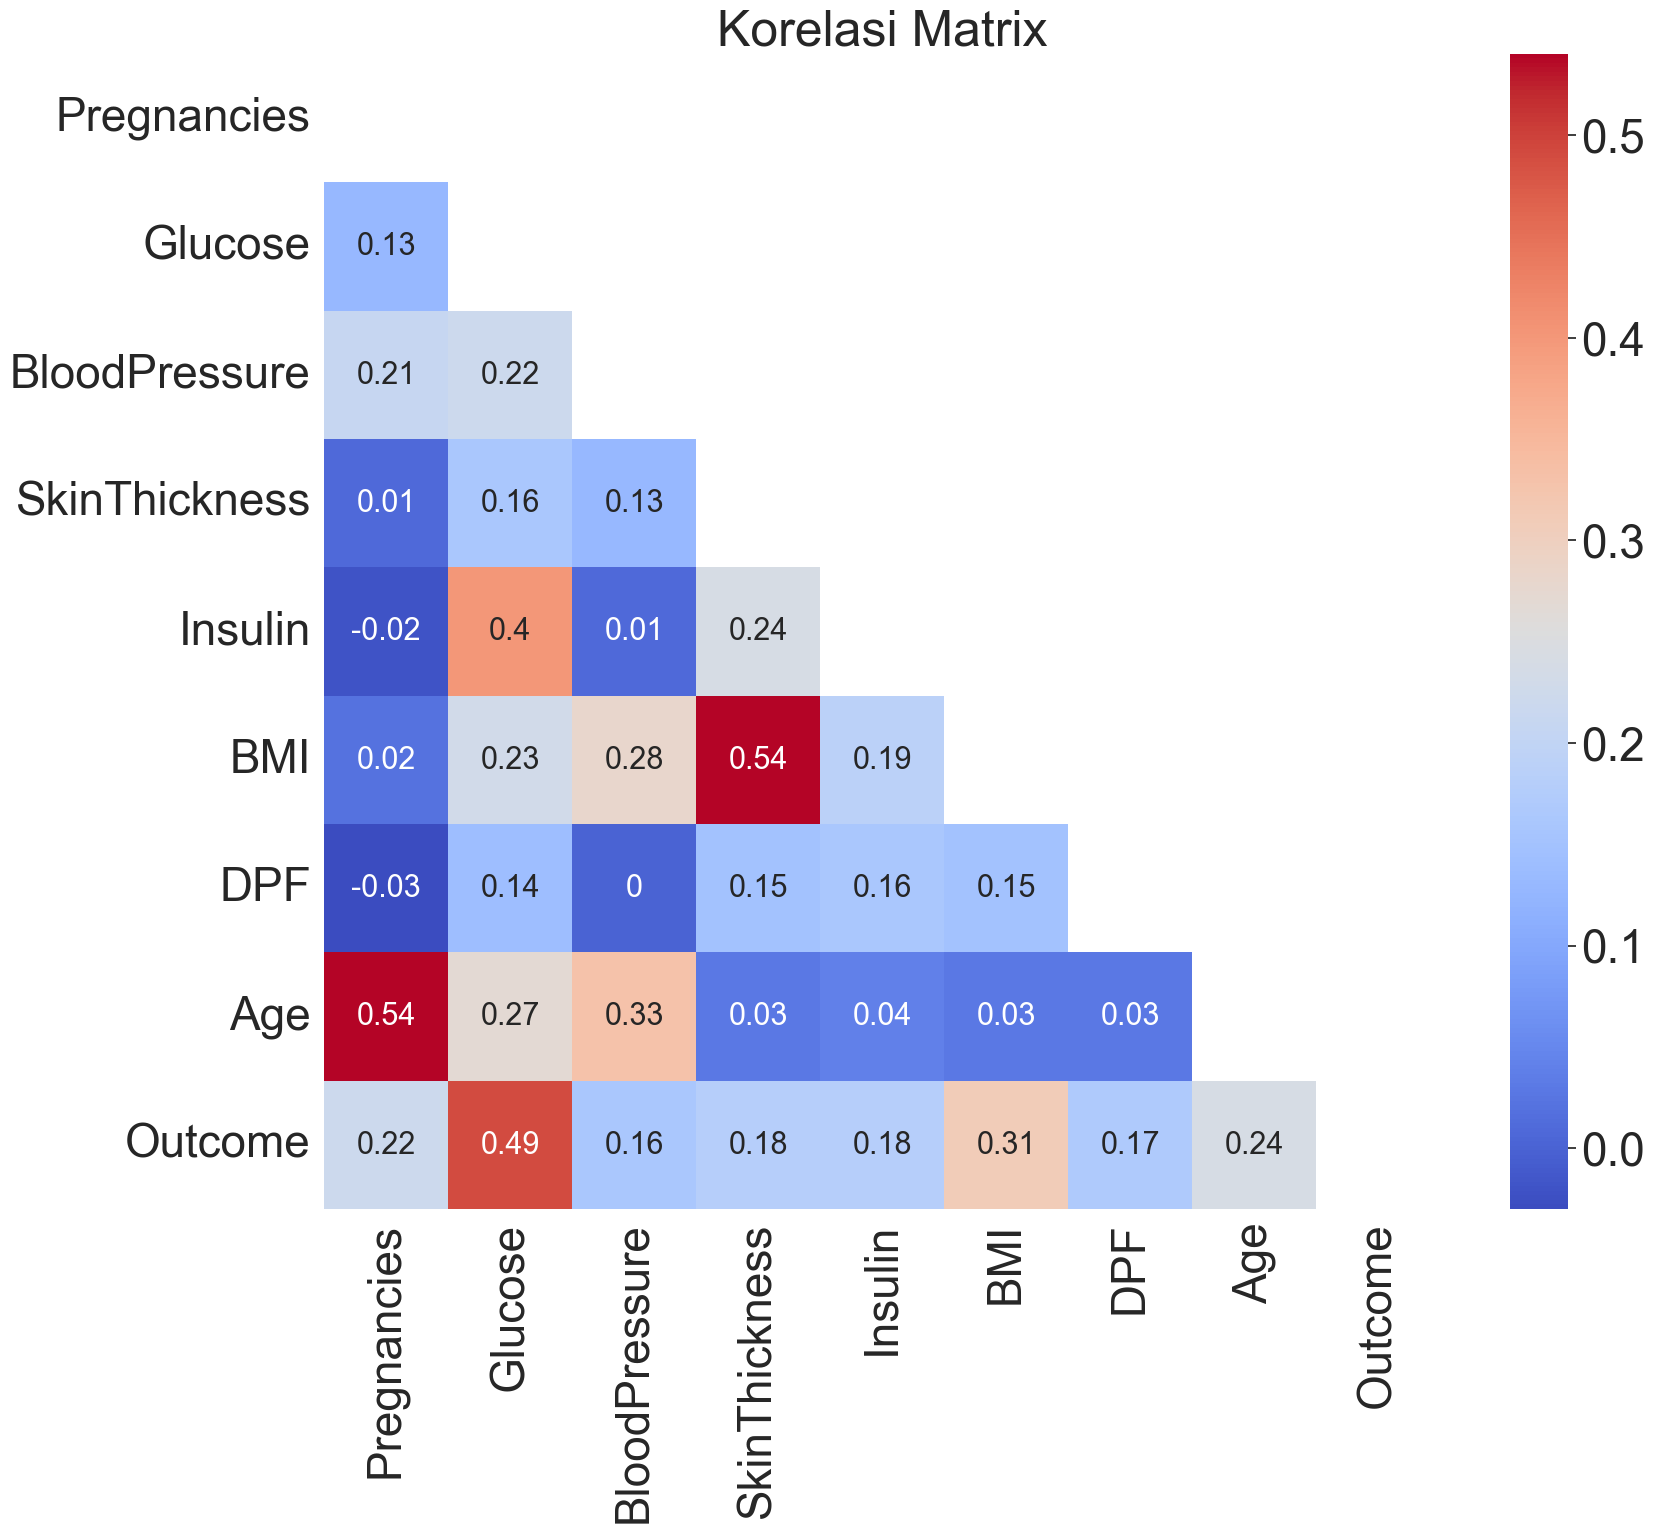

In [23]:
corr=dataset.corr().round(2)
plt.figure(figsize=(18,15))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask, cbar=True, annot_kws={"size": 22})
plt.title('Korelasi Matrix')

# Tahap 5: Pembuatan model dan pelatihan

In [24]:
def evaluate_classification_model(actual, predicted):
    accuracy = accuracy_score(actual, predicted)
    print(f"Akurasi: {accuracy:.4f}")
    precision = precision_score(actual,predicted)
    print(f"Presisi: {precision:.4f}")
    recall = recall_score(actual,predicted)
    print(f"Recall: {recall:.4f}")
    skor_f1 = f1_score(actual,predicted)
    print(f"f1-Score: {skor_f1:.4f}")

    class_report = classification_report(actual, predicted)
    print("Classification Report:")
    print(class_report)

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(class_counts) + 0.5, unique_classes_test, rotation=90)
    plt.yticks(np.arange(class_counts) + 0.5, unique_classes_test, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Akurasi: 0.7662
Presisi: 0.6863
Recall: 0.6364
f1-Score: 0.6604
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        99
           1       0.69      0.64      0.66        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.76       154



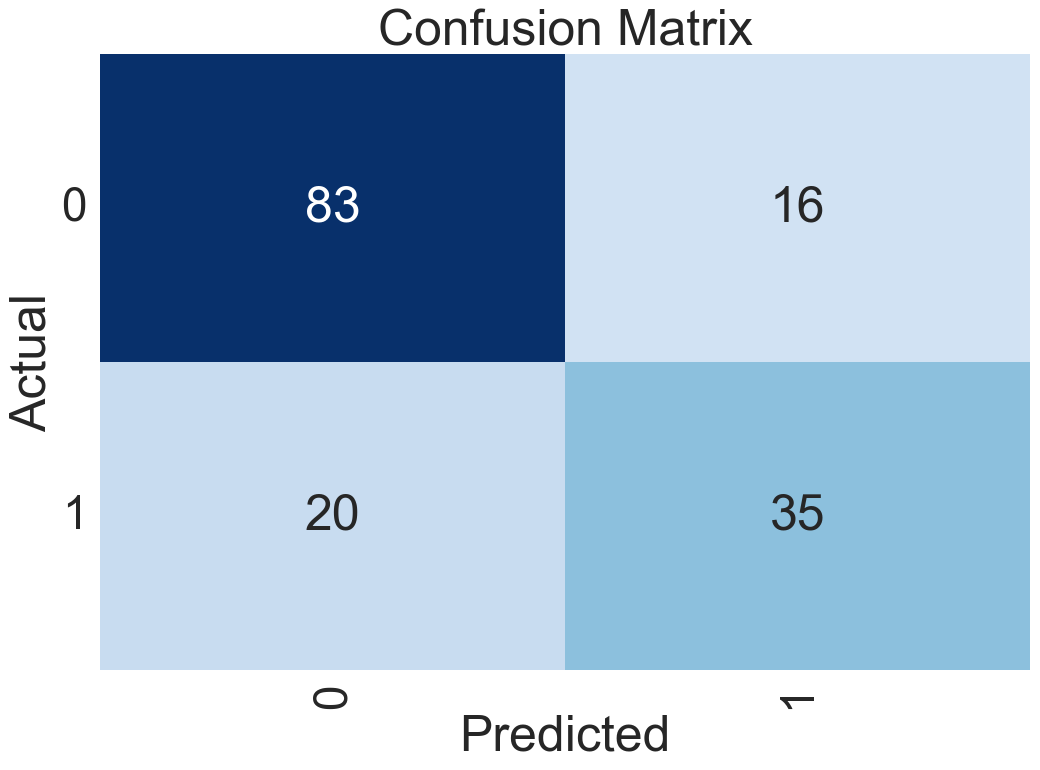

In [25]:
# SVM model
svc = SVC(kernel='linear', random_state=10)
svc.fit(X_train_scaled, y_train)
y_pred_svc = svc.predict(X_test_scaled)
evaluate_classification_model(y_test, y_pred_svc)

Akurasi: 0.7532
Presisi: 0.6667
Recall: 0.6182
f1-Score: 0.6415
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154



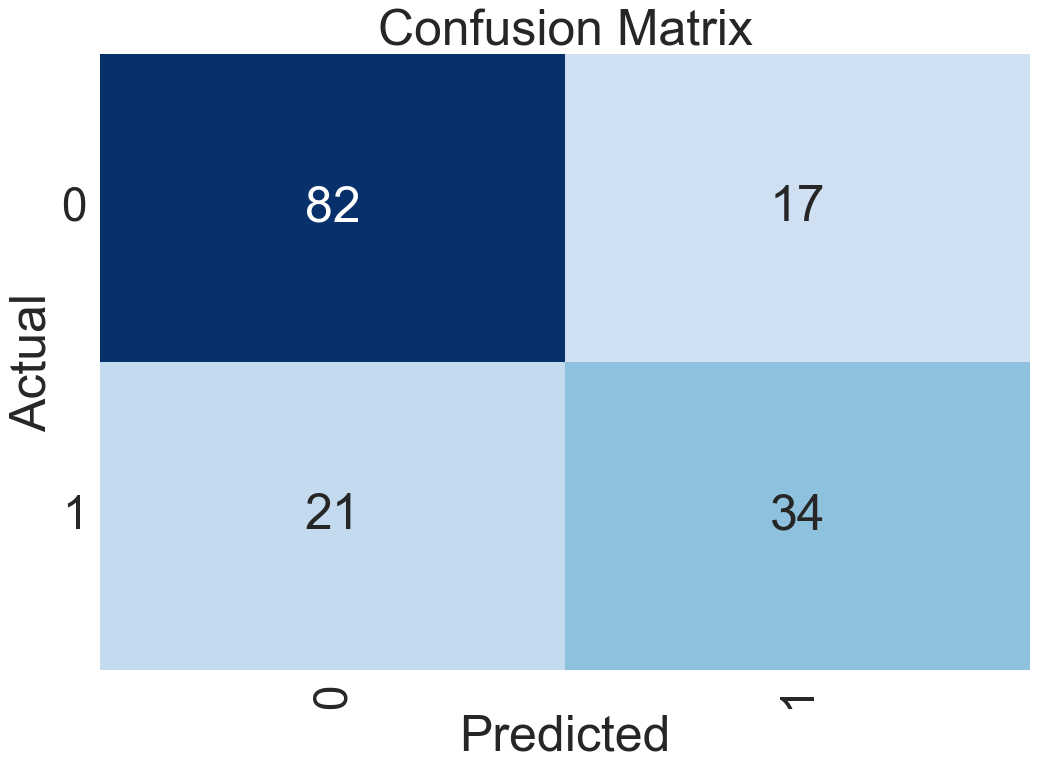

In [26]:
# KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

evaluate_classification_model(y_test, y_pred_knn)

# Tahap 6: Melakukan Optimasi Hiperparameter pada kedua model

In [38]:
# Hyperparameter grid untuk SVC
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search_svc = GridSearchCV(SVC(probability=True, random_state=10), param_grid_svc, cv=10, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_svc.fit(X_train_scaled, y_train)

best_params_svc = grid_search_svc.best_params_
best_score_svc = grid_search_svc.best_score_

print("Best Parameters SVC:", best_params_svc)
print("Best ROC-AUC Score SVC:", best_score_svc)

svc_best = SVC(**best_params_svc, random_state=10, probability=True)
svc_best.fit(X_train_scaled, y_train)

# Best Parameters for SVC: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'} untuk roc_auc
# svc_the_best = SVC(C=10, gamma=0.001, kernel="rbf", random_state=10, probability=True)
# svc_the_best = SVC(C=100, gamma=0.001, kernel="rbf", random_state=10, probability=True) 5 fold


Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best Parameters SVC: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best ROC-AUC Score SVC: 0.7719196192490745


SVC(C=100, gamma=0.001, probability=True, random_state=10)

Akurasi: 0.7727
Presisi: 0.6923
Recall: 0.6545
f1-Score: 0.6729
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83        99
           1       0.69      0.65      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



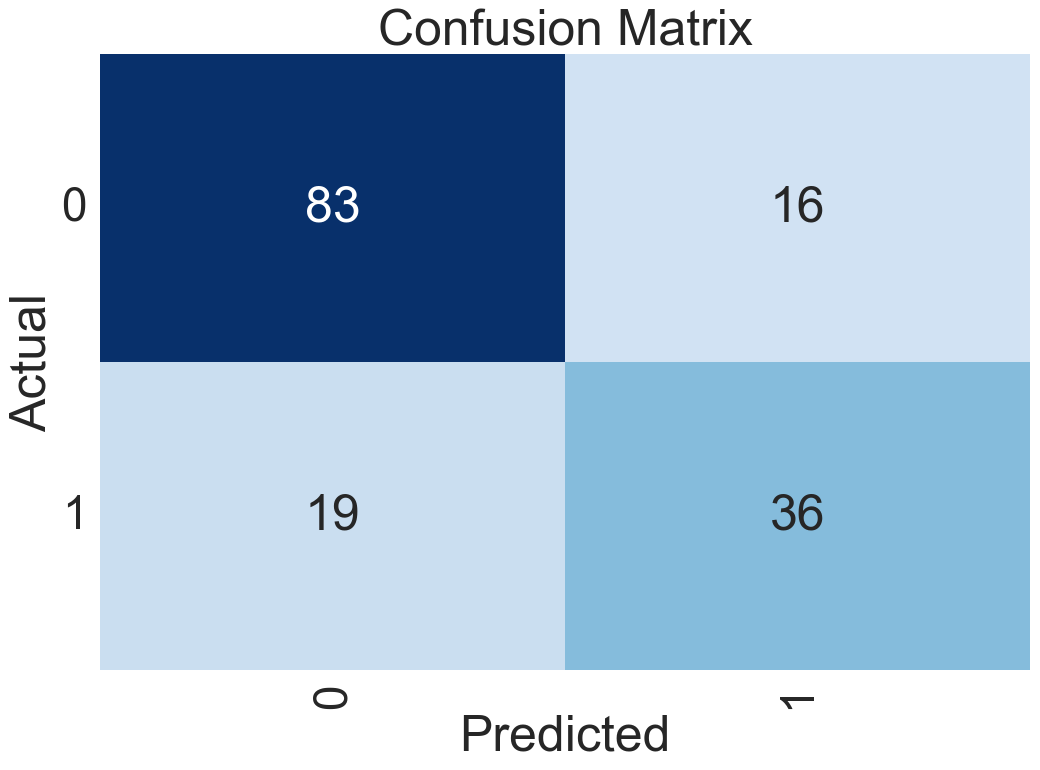

In [39]:
svc_the_best = SVC(C=100, gamma=0.001, kernel="rbf", random_state=10, probability=True)
svc_the_best.fit(X_train_scaled, y_train)
y_pred_svc_tuned = svc_the_best.predict(X_test_scaled)
evaluate_classification_model(y_test, y_pred_svc_tuned)

In [45]:
# Hyperparameter grid untuk KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=10, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_knn.fit(X_train_scaled, y_train)

best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

print("Best Parameters KNN:", best_params_knn)
print("Best ROC-AUC Score KNN:", best_score_knn)

knn_best = KNeighborsClassifier(**best_params_knn)
knn_best.fit(X_train_scaled, y_train)
# Best Parameters KNN: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'} untuk roc_auc
# knn_the_best = KNeighborsClassifier(n_neighbors=11, metric="euclidean", weights="uniform") old one best
# knn_the_best = KNeighborsClassifier(n_neighbors=15, metric="manhattan", weights="uniform") new one

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best Parameters KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best ROC-AUC Score KNN: 0.7573770491803279


KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance')

Akurasi: 0.7727
Presisi: 0.7083
Recall: 0.6182
f1-Score: 0.6602
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        99
           1       0.71      0.62      0.66        55

    accuracy                           0.77       154
   macro avg       0.76      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154



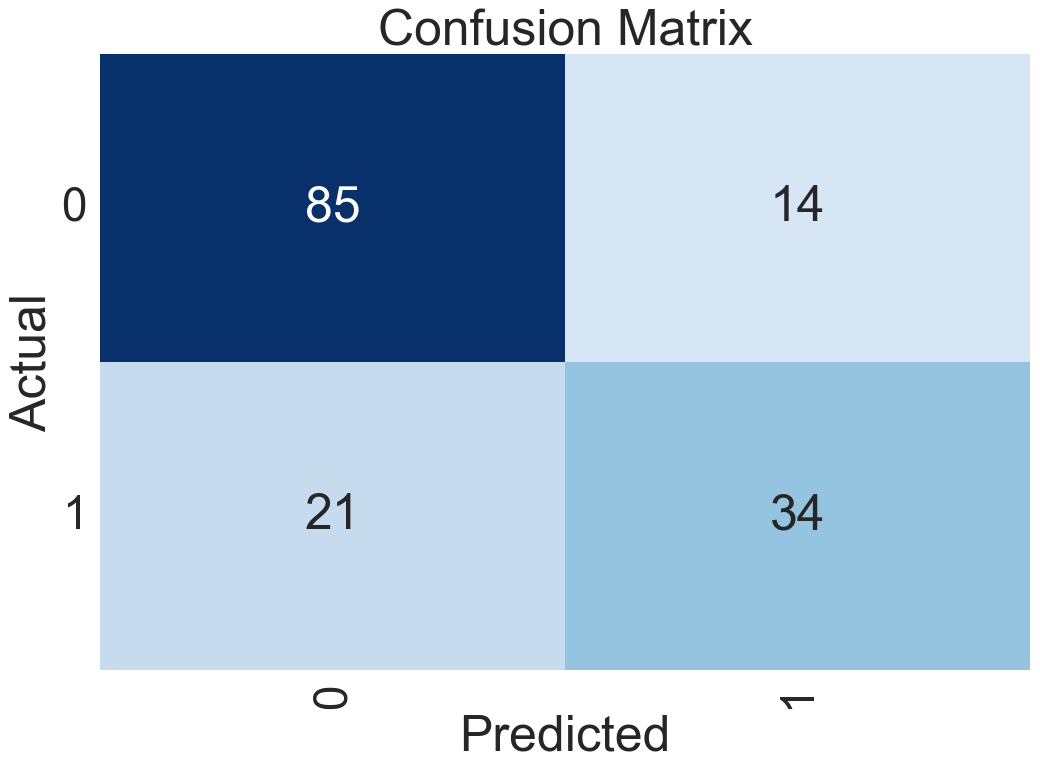

In [48]:
# KNN model
knn_the_best = KNeighborsClassifier(n_neighbors=11, metric="euclidean", weights="distance")
knn_the_best.fit(X_train_scaled, y_train)
y_pred_knn_tuned = knn_the_best.predict(X_test_scaled)

evaluate_classification_model(y_test, y_pred_knn_tuned)